# SSMR: generate SSM model from trajectory data

In [2]:
import numpy as np
from scipy.io import loadmat
from copy import deepcopy
from scipy.linalg import orth
import os

In [3]:
# %matplotlib qt
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2
import utils as utils
import plot_utils as plot

In [5]:
np.set_printoptions(linewidth=300)

In [6]:
use_data = "john" # "mine", "john"

In [7]:
if use_data == "mine":
    diamond_dir = "../../../soft-robot-control/examples/diamond"
    decayData_dir = os.path.join(diamond_dir, "dataCollection/origin")
    rest_file = os.path.join(diamond_dir, 'rest.pkl')

    output_node = 1354
    t_in = 2
    t_out = 5

    oData = utils.import_pos_data(decayData_dir, rest_file, output_node, t_in, t_out)

## Import and inspect data
See mat file in URL

In [8]:
dataDecayObs = loadmat("../dataDecayObs.mat") # , simplify_cells=True)

Data = {}
if use_data == "john":
    Data['oData'] = dataDecayObs['oData'].tolist()
    # Data['yData'] = dataDecayObs['yData'].tolist()
    # Xsnapshots = dataDecayObs['Xsnapshots']
    for i in range(len(Data['oData'])):
        Data['oData'][i][0] = Data['oData'][i][0].squeeze()
        # Data['yData'][i][0] = Data['yData'][i][0].squeeze()
else: # use my data
    Data['oData'] = oData

rDOF = 3
oDOF = 3
nTRAJ = len(Data['oData'])
SSMDim = 6

print("nTRAJ:", nTRAJ)

nTRAJ: 52


### Plot trajectories in an observable of interest

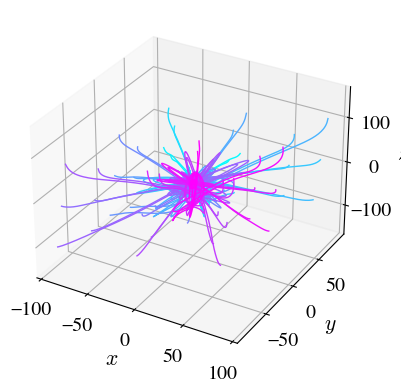

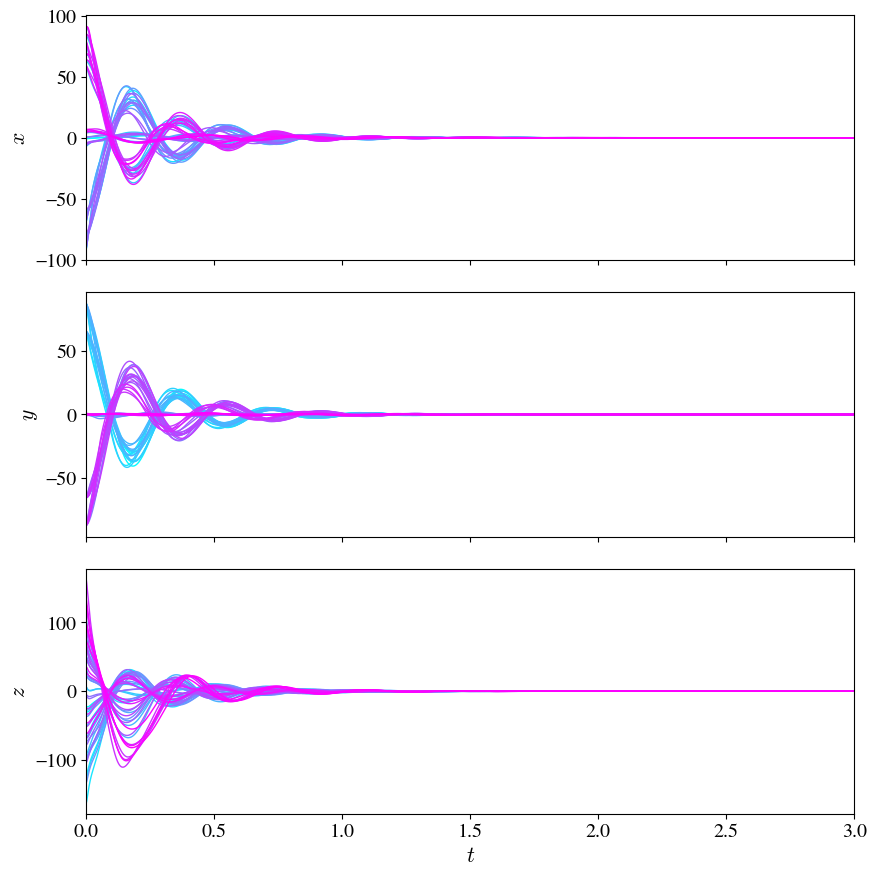

In [9]:
outdofs = [0, 1, 2]
plt.close('all')
# plot trajectories in 3D [x, y, z] space
plot.traj_3D(Data,
             xyz_idx=[('oData', 0), ('oData', 1), ('oData', 2)],
             xyz_names=[r'$x$', r'$y$', r'$z$'])
# plot evolution of x, y and z in time, separately in 3 subplots
highlight_traj = [] # [48, 49, 50, 51, 54, 55, 56, 57, 58, 59]
plot.traj_xyz(Data,
             xyz_idx=[('oData', 0), ('oData', 1), ('oData', 2)],
             xyz_names=[r'$x$', r'$y$', r'$z$'],
             highlight_idx=highlight_traj)
# plot trajectories in 3D [x, x_dot, z] space / NB: x_dot = v_x
# plot.traj_3D(Data,
#              xyz_idx=[('oData', 0), ('oData', 0+oDOF), ('oData', 2)],
#              xyz_names=[r'$x$', r'$\dot{x}$', r'$z$'])

Downsample data to $dt = 0.01$

In [10]:
if use_data == 'john':
    for i in range(nTRAJ):
        Data['oData'][i][0] = Data['oData'][i][0][::10]
        Data['oData'][i][1] = Data['oData'][i][1][:, ::10]

Compute reduced coordinates using delay embedding on the available oData

In [11]:
N_DELAY = 4

In [12]:
Data['yData'] = deepcopy(Data['oData'])
Data['yData'][0][1].shape
utils.delayEmbedding(Data['yData'][0][1], up_to_delay=N_DELAY)[:, :-4].shape

(15, 296)

In [13]:
Data['yData'] = deepcopy(Data['oData'])
for i in range(nTRAJ):
    delay_embedded_traj = utils.delayEmbedding(Data['oData'][i][1], up_to_delay=N_DELAY)
    Data['yData'][i][1] = delay_embedded_traj
    # Data['yData'][i][0] = Data['yData'][i][0][4:]

In [14]:
t_interval = [0.08, 2.6]
Data['oDataTrunc'] = utils.slice_trajectories(Data['oData'], t_interval)
Data['yDataTrunc'] = utils.slice_trajectories(Data['yData'], t_interval)

In [15]:
# print(Data['yDataTrunc'][0][1].shape)
# Data['yDataTrunc'][0][1][:, :5]
np.shape(Data['yData'][0][1])

(15, 300)

## Obtain reduced-order coordinates

### Perform PCA on delay-embedded coordinates to obtain reduced coordinates

In [16]:
# Perform SVD on displacement field
# if use_data == "mine":
from scipy.sparse.linalg import svds

Xsnapshots = np.hstack([yDataTrunc[1] for yDataTrunc in Data['yDataTrunc']])
# subsample dt=0.01
Xsnapshots = Xsnapshots[:, :]

# print(Xsnapshots.shape)
# print(Xsnapshots[:, 0:10])

v, s, u = svds(Xsnapshots, k=SSMDim, which="LM")
ind = np.argsort(s)[::-1]
s = s[ind]
v = v[:, ind]
# v, s, _ = np.linalg.svd(Xsnapshots, compute_uv=True)
# print(s)
# print(v)
l2vals = s**2

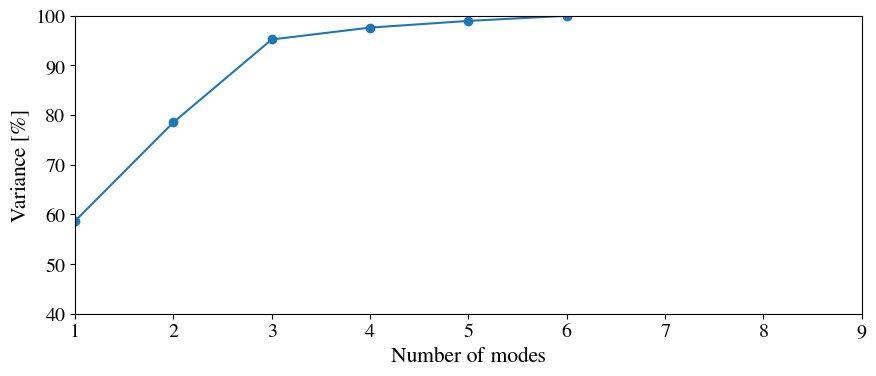

In [17]:
# Plot variance description: we expect three modes to capture almost all variance.
# Note we assume data centered around the origin, which is the fixed point of our system.
plt.close('all')
plot.pca_modes(l2vals, up_to_mode=9)

### Project delay-embedded data onto dominant modes

In [18]:
from copy import deepcopy
Data['etaDataTrunc'] = deepcopy(Data['yDataTrunc'])
Vde = v[:, :SSMDim]
for i in range(nTRAJ):
    Data['etaDataTrunc'][i][1] = Vde.T @ Data['yDataTrunc'][i][1]

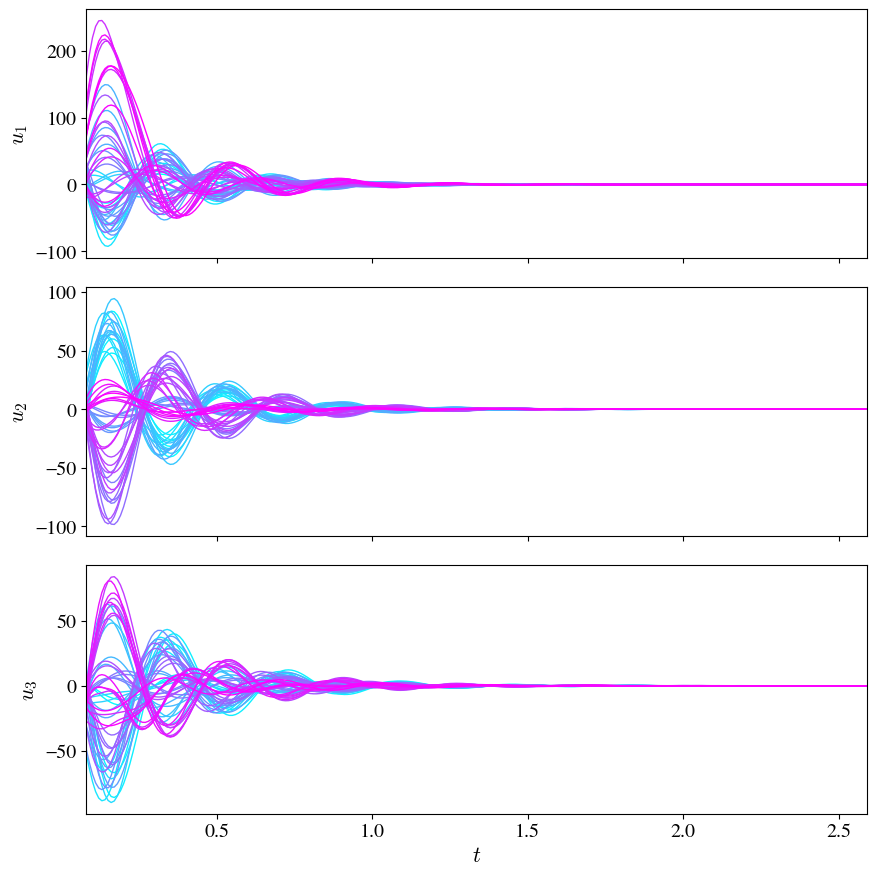

In [19]:
plt.close('all')
# plot first three reduced coordinates
plot.traj_xyz(Data,
              xyz_idx=[('etaDataTrunc', 0), ('etaDataTrunc', 1), ('etaDataTrunc', 2)],
              xyz_names=[r'$u_1$', r'$u_2$', r'$u_3$'])

### Train and test data (train/test split)

In [20]:
indTest = [0, 4] # [0, 2, 4, 6, 8, 10, 12, 14]
indTrain = [i for i in range(nTRAJ) if i not in indTest]

## SSMLearn

Start Matlab engine and install/run SSMLearn

In [21]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd("../..", nargout=0)
eng.install(nargout=0)
eng.cd("ROM/")

SSMLearn: Data-driven Reduced Order Models for Nonlinear Dynamical Systems
Maintained by Mattia Cenedese (mattiac@ethz.ch) and Joar Axs (jgoeransson@ethz.ch)
License: GNUv3.0
> In path (line 109)
In addpath (line 86)
In install (line 20)


'/home/jalora/SSMR-for-control'

Bring data in a format that is accepted by the (slightly modified) version of SSMLearn (requires a specific cell array structure for input data)

In [22]:
# make data ready for Matlab
yDataTruncTrain_matlab = [[], []]
etaDataTruncTrain_matlab = [[], []]
for i in indTrain:
    yDataTruncTrain_matlab[0].append(matlab.double(initializer=Data['yDataTrunc'][i][0].tolist()))
    yDataTruncTrain_matlab[1].append(matlab.double(initializer=Data['yDataTrunc'][i][1].tolist()))
    etaDataTruncTrain_matlab[0].append(matlab.double(initializer=Data['etaDataTrunc'][i][0].tolist()))
    etaDataTruncTrain_matlab[1].append(matlab.double(initializer=Data['etaDataTrunc'][i][1].tolist()))


### Learn geometry of the SSM

Find parametrization of SSM using SSMLearn

In [23]:
SSMOrder = 3

print(Data['etaDataTrunc'][0][1].shape)

IMInfo = eng.IMGeometry(yDataTruncTrain_matlab, SSMDim, SSMOrder,
                        'reducedCoordinates', etaDataTruncTrain_matlab)
# IMInfoInv = eng.IMGeometry(yDataTruncTrain_matlab, obsDim, SSMOrder,
#                            'reducedCoordinates', oDataTruncTrain_matlab)


(6, 252)


Data seems to have been fed from Python!


In [24]:
IMInfo['chart']

{'map': matlab.double([])}

### Learn dynamics on the SSM (reduced dynamics)

Find parametrization of reduced dynamics using SSMLearn

In [25]:
ROMOrder = 3
RDInfo = eng.IMDynamicsFlow(etaDataTruncTrain_matlab, 'R_PolyOrd', ROMOrder, 'style', 'default')

Data seems to have been fed from Python!
Estimation of the reduced dynamics... 
 Done. 


Stop Matlab engine -- not needed anymore

In [26]:
eng.quit()

Convert all matlab double arrays to numpy arrays

In [27]:
def convert_matlab_arrays_to_numpy_arrays(info_dict):
  for k,v in info_dict.items():        
     if isinstance(v, dict):
         convert_matlab_arrays_to_numpy_arrays(v)
     else:            
        if isinstance(v, matlab.double):
           info_dict[k] = np.array(v)

convert_matlab_arrays_to_numpy_arrays(IMInfo)
convert_matlab_arrays_to_numpy_arrays(RDInfo)

Stability analysis of reduced dynamics

In [28]:
assert np.all(np.real(RDInfo['eigenvaluesLinPartFlow']) < 0)
RDInfo['eigenvaluesLinPartFlow']

array([[-3.51792243+16.79631053j],
       [-3.59211715+17.05892314j],
       [-3.53843913+18.1953577j ],
       [-3.51792243-16.79631053j],
       [-3.59211715-17.05892314j],
       [-3.53843913-18.1953577j ]])

## Analyze the obtained mappings of SSM geometry and reduced dynamics

### SSM geometry (parametrization)

In [29]:
yRec = {}
errorGeo = {}
meanErrorGeo = {}

#### Train error

In [30]:
yRec['Train'] = utils.lift_trajectories(IMInfo, [Data['etaDataTrunc'][i] for i in indTrain])
errorGeo['Train'] = utils.compute_trajectory_errors(yRec['Train'], [Data['yDataTrunc'][i] for i in indTrain])[0] * 100

meanErrorGeo['Train'] = np.mean(errorGeo['Train'])
print(f"Average parametrization train error: {meanErrorGeo['Train']:.4e}")

Average parametrization train error: 1.5876e-02


#### Test error

In [31]:
yRec['Test'] = utils.lift_trajectories(IMInfo, [Data['etaDataTrunc'][i] for i in indTest])
errorGeo['Test'] = utils.compute_trajectory_errors(yRec['Test'], [Data['yDataTrunc'][i] for i in indTest])[0] * 100

meanErrorGeo['Test'] = np.mean(errorGeo['Test'])
print(f"Average parametrization test error: {meanErrorGeo['Test']:.4e}")

Average parametrization test error: 1.6448e-02


Plot comparison of SSM-predicted vs. actual test trajectories

In [32]:
print(Data['yData'][0][1].shape)
print(yRec['Test'][0][1].shape)

(15, 300)
(15, 252)


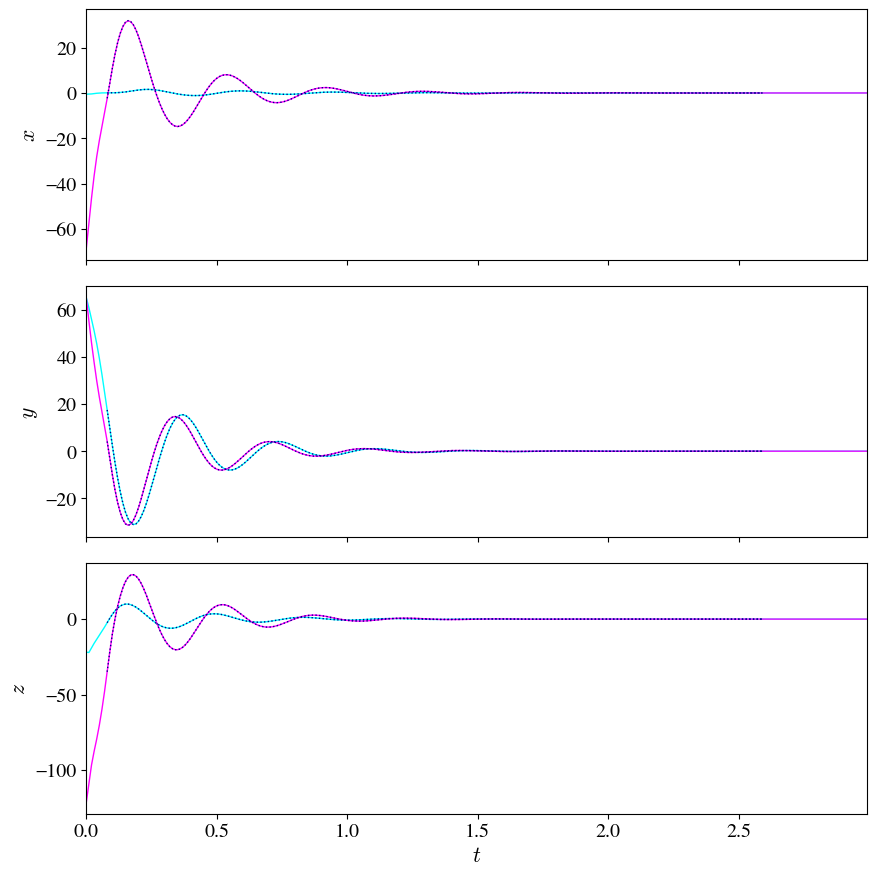

In [33]:
plt.close('all')
axs = plot.traj_xyz(Data,
                    xyz_idx=[('yData', 0), ('yData', 1), ('yData', 2)],
                    xyz_names=[r'$x$', r'$y$', r'$z$'],
                    traj_idx=indTest,
                    show=False)
plot.traj_xyz(yRec,
              xyz_idx=[('Test', 0), ('Test', 1), ('Test', 2)],
              xyz_names=[r'$x$', r'$y$', r'$z$'],
              axs=axs, ls=':', color='darkblue')

### Reduced dynamics

In [34]:
etaRec = {}
etaRec['RD'] = utils.advectRD(RDInfo, Data['etaDataTrunc'])[0]
meanErrorDyn = {}

for i in range(nTRAJ):
    if etaRec['RD'][i][1].shape[1] != Data['etaDataTrunc'][i][1].shape[1]:
        print(i)

normedTrajDist = utils.compute_trajectory_errors(etaRec['RD'], Data['etaDataTrunc'])[0]
meanErrorDyn['Train'] = np.mean(normedTrajDist[indTrain]) * 100
meanErrorDyn['Test'] = np.mean(normedTrajDist[indTest]) * 100

print(f"Average dynamics train error: {meanErrorDyn['Train']:.4f}")
print(f"Average dynamics test error: {meanErrorDyn['Test']:.4f}")

Average dynamics train error: 1.0944
Average dynamics test error: 1.1892


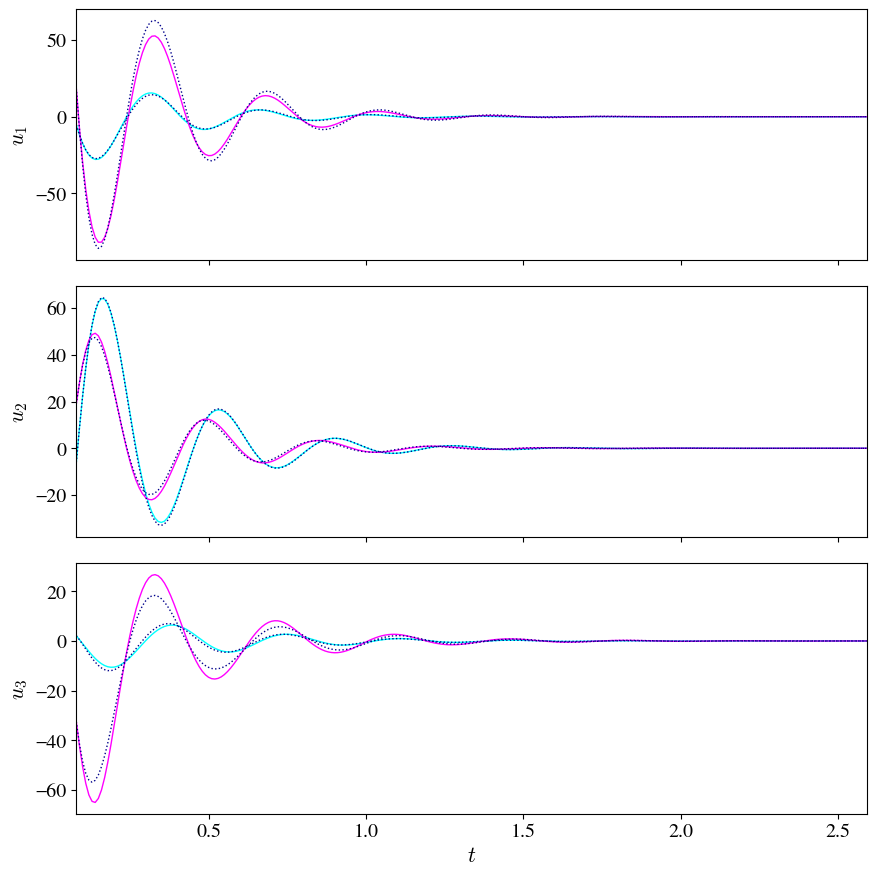

In [35]:
plot_all = False
if plot_all:
    vPlot = range(nTRAJ)
else:
    vPlot = indTest

plt.close('all')
axs = plot.traj_xyz(Data,
                    xyz_idx=[('etaDataTrunc', 0), ('etaDataTrunc', 1), ('etaDataTrunc', 2)],
                    xyz_names=[r'$u_1$', r'$u_2$', r'$u_3$'],
                    traj_idx=vPlot,
                    show=False)
plot.traj_xyz(etaRec,
              xyz_idx=[('RD', 0), ('RD', 1), ('RD', 2)],
              xyz_names=[r'$u_1$', r'$u_2$', r'$u_3$'],
              traj_idx=vPlot,
              axs=axs, ls=':', color='darkblue')


### Global error

In [36]:
errorGlo = {}
meanErrorGlo = {}

#### Train error

In [37]:
yRec['RDTrain'] = utils.lift_trajectories(IMInfo, [etaRec['RD'][i] for i in indTrain])
errorGlo['Train'] = utils.compute_trajectory_errors(yRec['RDTrain'], [Data['yDataTrunc'][i] for i in indTrain])[0] * 100

meanErrorGlo['Train'] = np.mean(errorGlo['Train'])
print(f"Average global train error: {meanErrorGlo['Train']:.4f}")

Average global train error: 1.0957


#### Test error

In [38]:
yRec['RDTest'] = utils.lift_trajectories(IMInfo, [etaRec['RD'][i] for i in indTest])
errorGlo['Test'] = utils.compute_trajectory_errors(yRec['RDTest'], [Data['yDataTrunc'][i] for i in indTest])[0] * 100

meanErrorGlo['Test'] = np.mean(errorGlo['Test'])
print(f"Average global test error: {meanErrorGlo['Test']:.4f}")

Average global test error: 1.1903


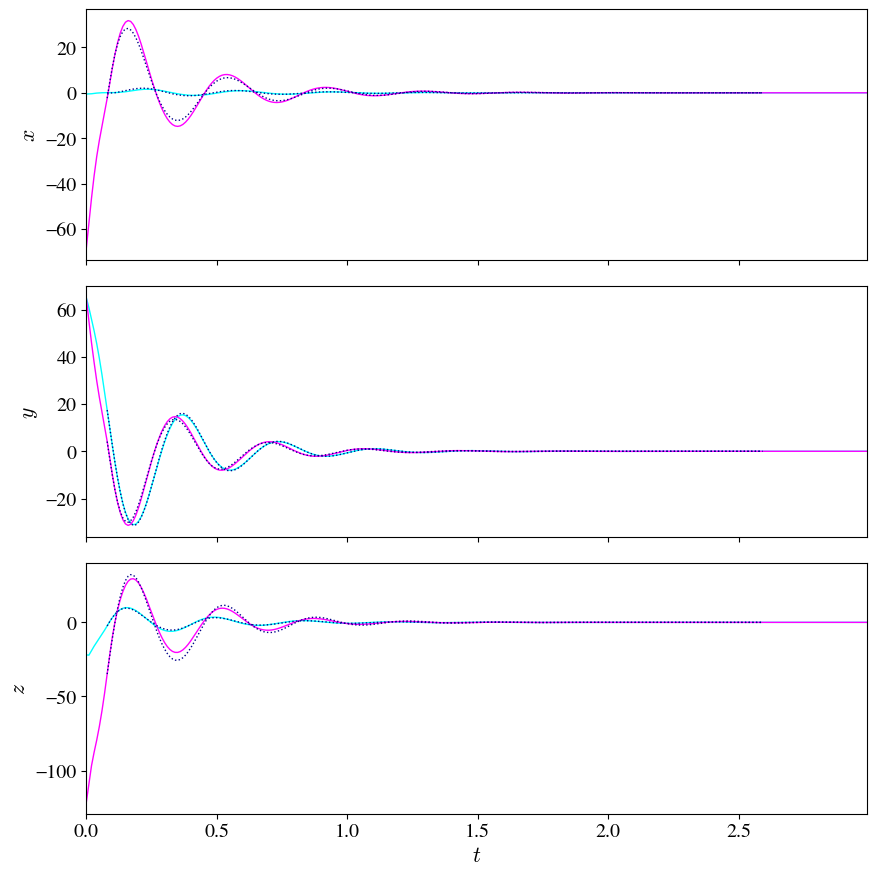

In [39]:
plt.close('all')
axs = plot.traj_xyz(Data,
                    xyz_idx=[('yData', 0), ('yData', 1), ('yData', 2)],
                    xyz_names=[r'$x$', r'$y$', r'$z$'],
                    traj_idx=indTest,
                    show=False)
plot.traj_xyz(yRec,
              xyz_idx=[('RDTest', 0), ('RDTest', 1), ('RDTest', 2)],
              xyz_names=[r'$x$', r'$y$', r'$z$'],
              axs=axs, ls=':', color='darkblue')

In [40]:
IMInfo

{'chart': {'map': array([], shape=(0, 0), dtype=float64)},
 'parametrization': {'map': <matlab.object at 0x7fa2f86c5e10>,
  'polynomialOrder': 3,
  'dimension': 6,
  'tangentSpaceAtOrigin': array([[-8.94526834e-02, -8.94071360e-02, -4.15339671e-01, -2.40639509e-01, -2.50525487e-01, -5.55131748e-01],
         [ 5.31394625e-02, -4.23693415e-01,  7.78322871e-02,  1.58243921e-01, -6.01002215e-01,  2.04042424e-01],
         [-4.27980022e-01, -4.63176966e-02,  1.12532723e-01, -5.82480041e-01, -5.28590661e-02,  2.69026867e-01],
         [-9.11781743e-02, -8.90977746e-02, -4.36643971e-01, -1.17896918e-01, -1.19875203e-01, -2.56144935e-01],
         [ 5.31595070e-02, -4.44745222e-01,  7.86518250e-02,  8.08352199e-02, -2.80275305e-01,  9.56917502e-02],
         [-4.46545289e-01, -3.96734733e-02,  1.08366179e-01, -2.70748035e-01, -2.57635950e-02,  1.25918737e-01],
         [-9.10090219e-02, -8.63363265e-02, -4.43393165e-01, -5.93593714e-04,  4.69975878e-03,  2.78325462e-02],
         [ 5.12306586

## Change Coordinates for Control Observables

In [41]:
# Start Matlab again
eng = matlab.engine.start_matlab()
eng.cd("../..", nargout=0)
eng.install(nargout=0)
eng.cd("ROM/")

SSMLearn: Data-driven Reduced Order Models for Nonlinear Dynamical Systems
Maintained by Mattia Cenedese (mattiac@ethz.ch) and Joar Axs (jgoeransson@ethz.ch)
License: GNUv3.0
> In path (line 109)
In addpath (line 86)
In install (line 20)


'/home/jalora/SSMR-for-control'

### Load New Observables (Delay of tip position)

In [42]:
Data['yDataTruncNew'] = deepcopy(Data['yDataTrunc'])
for iTraj in range(len(Data['yDataTrunc'])):
    Data['yDataTruncNew'][iTraj][1] = Data['yDataTrunc'][iTraj][1][-6:, :]

# print(oDOF)
# test = Data['yDataTrunc'][0][1][-6:, :]

# Repopulate yDataTruncTrain with new observables
yDataTruncTrain_matlab = [[], []]
etaDataTruncTrain_matlab = [[], []]

for iTraj in indTrain:
    yDataTruncTrain_matlab[0].append(matlab.double(initializer=Data['yDataTruncNew'][iTraj][0].tolist()))
    yDataTruncTrain_matlab[1].append(matlab.double(initializer=Data['yDataTruncNew'][iTraj][1].tolist()))
    etaDataTruncTrain_matlab[0].append(matlab.double(initializer=Data['etaDataTrunc'][iTraj][0].tolist()))
    etaDataTruncTrain_matlab[1].append(matlab.double(initializer=Data['etaDataTrunc'][iTraj][1].tolist()))

IMInfo_paramonly = eng.IMGeometry(yDataTruncTrain_matlab, SSMDim, SSMOrder,
                        'reducedCoordinates', etaDataTruncTrain_matlab, 'style', 'custom')

Data seems to have been fed from Python!


In [43]:
# Not orthogonal since new observables (eta was orthogonal projection of full delayed observables)
tanspace0_not_orth = IMInfo_paramonly['parametrization']['tangentSpaceAtOrigin']
tanspace0 = orth(tanspace0_not_orth)

# Change coordinates and repopulate eta
Data['etaDataTruncNew'] = deepcopy(Data['etaDataTrunc'])
for iTraj in range(len(Data['etaDataTruncNew'])):
    Data['etaDataTruncNew'][iTraj][1] = np.transpose(tanspace0) @ tanspace0_not_orth @ Data['etaDataTrunc'][iTraj][1]

etaDataTruncTrain_matlab = [[], []]
for iTraj in indTrain:
    etaDataTruncTrain_matlab[0].append(matlab.double(initializer=Data['etaDataTrunc'][iTraj][0].tolist()))
    etaDataTruncTrain_matlab[1].append(matlab.double(initializer=Data['etaDataTruncNew'][iTraj][1].tolist()))

IMInfo_paramonly = eng.IMGeometry(yDataTruncTrain_matlab, SSMDim, SSMOrder,
                        'reducedCoordinates', etaDataTruncTrain_matlab, 'style', 'custom')
IMInfo_chartonly = eng.IMGeometry(etaDataTruncTrain_matlab, SSMDim, SSMOrder,
                        'reducedCoordinates', yDataTruncTrain_matlab, 'style', 'custom', 'Ve', np.transpose(tanspace0))

Data seems to have been fed from Python!
Data seems to have been fed from Python!


In [45]:
tanspace0

array([[-0.29404356,  0.08057132,  0.51289566,  0.01084548, -0.05775258,  0.80033225],
       [-0.08273635, -0.58855271,  0.04501306, -0.03013112,  0.80027704,  0.05816363],
       [-0.50987099,  0.04897107, -0.3029575 ,  0.80301897,  0.03106735, -0.00674628],
       [-0.39756187,  0.10842632,  0.68860154, -0.00591093,  0.04293574, -0.59509478],
       [-0.11241043, -0.79278352,  0.05994065,  0.02220827, -0.59406817, -0.04307096],
       [-0.68995153,  0.06673696, -0.4066493 , -0.59464853, -0.02226348,  0.00684622]])

### Results of New Parameterization and Chart Fit

In [63]:
## Parameterization (TODO: Fix this)
# Train
yRec['Train'] = utils.lift_trajectories(IMInfo_paramonly, [Data['etaDataTruncNew'][i] for i in indTrain])
errorGeo['Train'] = utils.compute_trajectory_errors(yRec['Train'], [Data['yDataTruncNew'][i] for i in indTrain])[0] * 100
# Test
yRec['Test'] = utils.lift_trajectories(IMInfo_paramonly, [Data['etaDataTruncNew'][i] for i in indTest])
errorGeo['Test'] = utils.compute_trajectory_errors(yRec['Test'], [Data['yDataTruncNew'][i] for i in indTest])[0] * 100

meanErrorGeo['Train'] = np.mean(errorGeo['Train'])
print(f"Average parametrization train error: {meanErrorGeo['Train']:.4e}")
meanErrorGeo['Test'] = np.mean(errorGeo['Test'])
print(f"Average parametrization Test error: {meanErrorGeo['Test']:.4e}")

## Chart
# Train
etaRec['Train'] = utils.lift_trajectories(IMInfo_chartonly, [Data['yDataTruncNew'][i] for i in indTrain])
errorGeo['Train'] = utils.compute_trajectory_errors(etaRec['Train'], [Data['etaDataTruncNew'][i] for i in indTrain])[0] * 100
# Test
etaRec['Test'] = utils.lift_trajectories(IMInfo_chartonly, [Data['yDataTruncNew'][i] for i in indTest])
errorGeo['Test'] = utils.compute_trajectory_errors(etaRec['Test'], [Data['etaDataTruncNew'][i] for i in indTest])[0] * 100

meanErrorGeo['Train'] = np.mean(errorGeo['Train'])
print(f"Average Chart train error: {meanErrorGeo['Train']:.4e}")
meanErrorGeo['Test'] = np.mean(errorGeo['Test'])
print(f"Average Chart Test error: {meanErrorGeo['Test']:.4e}")

Average parametrization train error: 1.4530e-02
Average parametrization Test error: 1.4363e-02
Average Chart train error: 1.5035e-02
Average Chart Test error: 1.6208e-02


### Define Rotated Geometry and Reduced Dynamics

In [64]:
# Define new Geometry
IMInfo = {'chart': IMInfo_chartonly['parametrization'], 'parametrization': IMInfo_paramonly['parametrization']}
# print(IMInfo['parametrization'])

# Define new Reduced dynamics
ROMOrder = 3
RDInfo = eng.IMDynamicsFlow(etaDataTruncTrain_matlab, 'R_PolyOrd', ROMOrder, 'style', 'default')
Rauton = RDInfo['reducedDynamics']['map']
convert_matlab_arrays_to_numpy_arrays(RDInfo)

etaRec['RD'] = utils.advectRD(RDInfo, Data['etaDataTruncNew'])[0]
yRec['Train'] = utils.lift_trajectories(IMInfo, [Data['etaDataTruncNew'][i] for i in indTrain])
yRec['Test'] = utils.lift_trajectories(IMInfo, [Data['etaDataTruncNew'][i] for i in indTest])

Data seems to have been fed from Python!
Estimation of the reduced dynamics... 
 Done. 


In [65]:
# Shutdown matlab
eng.quit()

In [66]:
# Check Reduced dynamics Error
meanErrorDyn = {}
# DEBUG: Check without rotation
# Data['etaDataTruncNew'] = Data['etaDataTrunc']
# Data['yDataTruncNew'] = Data['yDataTrunc']


for i in range(nTRAJ):
    if etaRec['RD'][i][1].shape[1] != Data['etaDataTruncNew'][i][1].shape[1]:
        print(i)

normedTrajDist = utils.compute_trajectory_errors(etaRec['RD'], Data['etaDataTruncNew'])[0]
meanErrorDyn['Train'] = np.mean(normedTrajDist[indTrain]) * 100
meanErrorDyn['Test'] = np.mean(normedTrajDist[indTest]) * 100

print(f"Average dynamics train error: {meanErrorDyn['Train']:.4f}")
print(f"Average dynamics test error: {meanErrorDyn['Test']:.4f}")

Average dynamics train error: 1.0359
Average dynamics test error: 1.1188


### Plot New Reduced Dynamics

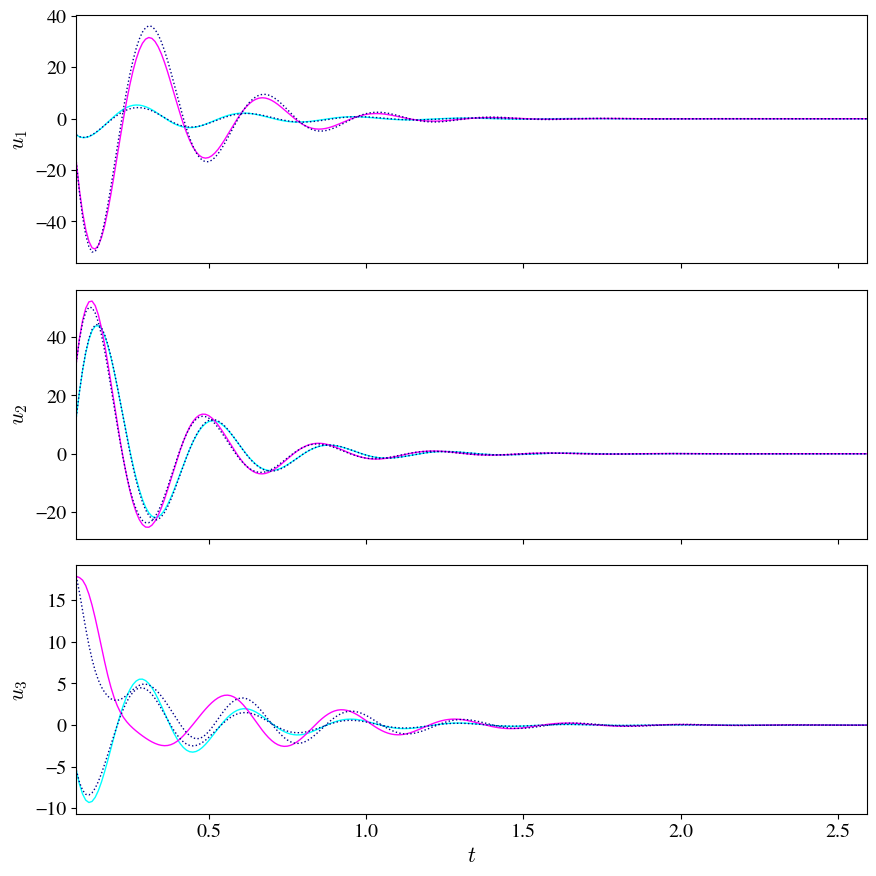

In [67]:
plot_all = False
if plot_all:
    vPlot = range(nTRAJ)
else:
    vPlot = indTest

plt.close('all')
axs = plot.traj_xyz(Data,
                    xyz_idx=[('etaDataTruncNew', 0), ('etaDataTruncNew', 1), ('etaDataTruncNew', 2)],
                    xyz_names=[r'$u_1$', r'$u_2$', r'$u_3$'],
                    traj_idx=vPlot,
                    show=False)
plot.traj_xyz(etaRec,
              xyz_idx=[('RD', 0), ('RD', 1), ('RD', 2)],
              xyz_names=[r'$u_1$', r'$u_2$', r'$u_3$'],
              traj_idx=vPlot,
              axs=axs, ls=':', color='darkblue')

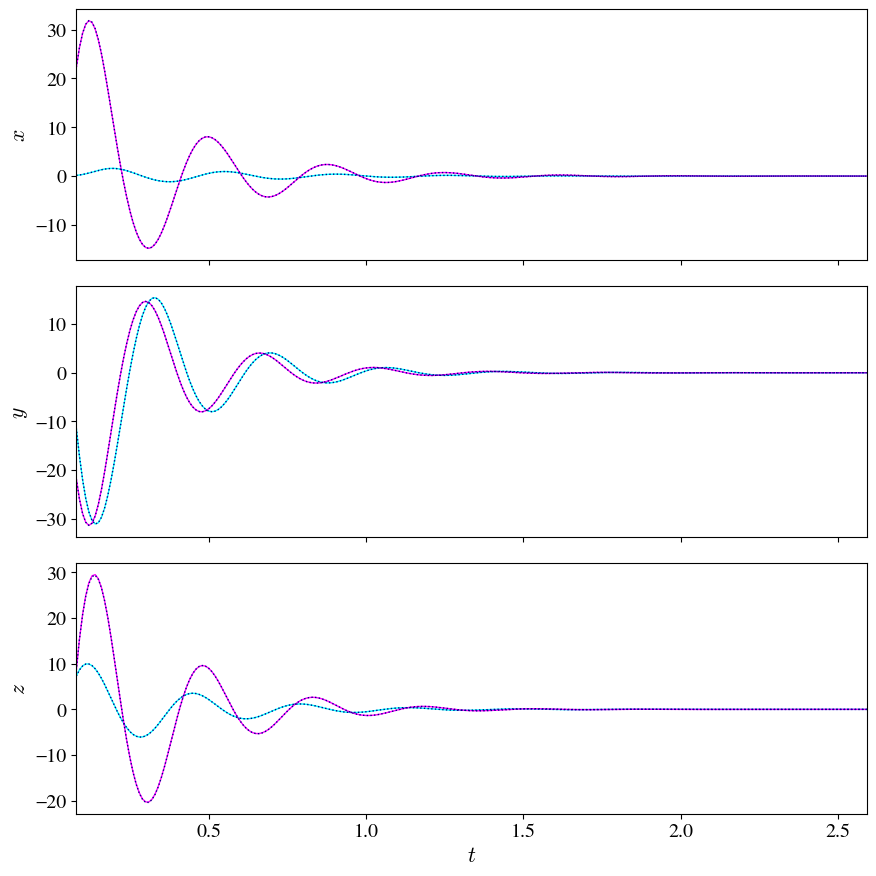

In [68]:
outdofs = [3, 4, 5]
plt.close('all')
axs = plot.traj_xyz(Data,
                    xyz_idx=[('yDataTruncNew', outdofs[0]), ('yDataTruncNew', outdofs[1]), ('yDataTruncNew', outdofs[2])],
                    xyz_names=[r'$x$', r'$y$', r'$z$'],
                    traj_idx=indTest,
                    show=False)
plot.traj_xyz(yRec,
              xyz_idx=[('Test', outdofs[0]), ('Test', outdofs[1]), ('Test', outdofs[2])],
              xyz_names=[r'$x$', r'$y$', r'$z$'],
              axs=axs, ls=':', color='darkblue')

## Control

### Setup model for control

In [69]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d 

In [70]:
Rauton = utils.Rauton(RDInfo)
Vauton = lambda x: IMInfo['parametrization']['H'] @ utils.multivariate_polynomial(x, IMInfo['parametrization']['polynomialOrder'])
Wauton = lambda y: IMInfo['chart']['H'] @ utils.multivariate_polynomial(y, IMInfo['chart']['polynomialOrder'])

### Learn control matrix $B$

Use figure8 trajectory as the training data

In [71]:
# Load the controls and actual trajectories for figure8
u_train = np.loadtxt("../../system_data/u_big.csv", delimiter=',').T
z_train = np.loadtxt("../../system_data/z_big.csv", delimiter=',').T
z_eq_train = np.loadtxt("../../system_data/z_equilibrium.csv", delimiter=',')
print(z_eq_train)

# tip position, normalized using resting position
z_shift_train = (z_train[-3:, :].T - z_eq_train).T

# original spacing of inputs
T = 10.01
dt = 0.01
N = int(T / dt)
t_train = np.linspace(0, T, N+1)

[-7.07686434  1.2132194  97.04053866]


Use randomly sampled (step) inputs as the training data

In [72]:
diamond_train_full = loadmat("../diamond_train_full.mat", simplify_cells=True)
z_train, u_train, _ = diamond_train_full['y'].T, diamond_train_full['u'].T, diamond_train_full['t']
print(z_train.shape)

# tip position, normalized using resting position
z_shift_train = (z_train[-3:, :].T - z_train[-3:, 0]).T
dt = 0.01
t_train = np.arange(z_train.shape[1]) * dt

(6, 8692)


Plot the training data

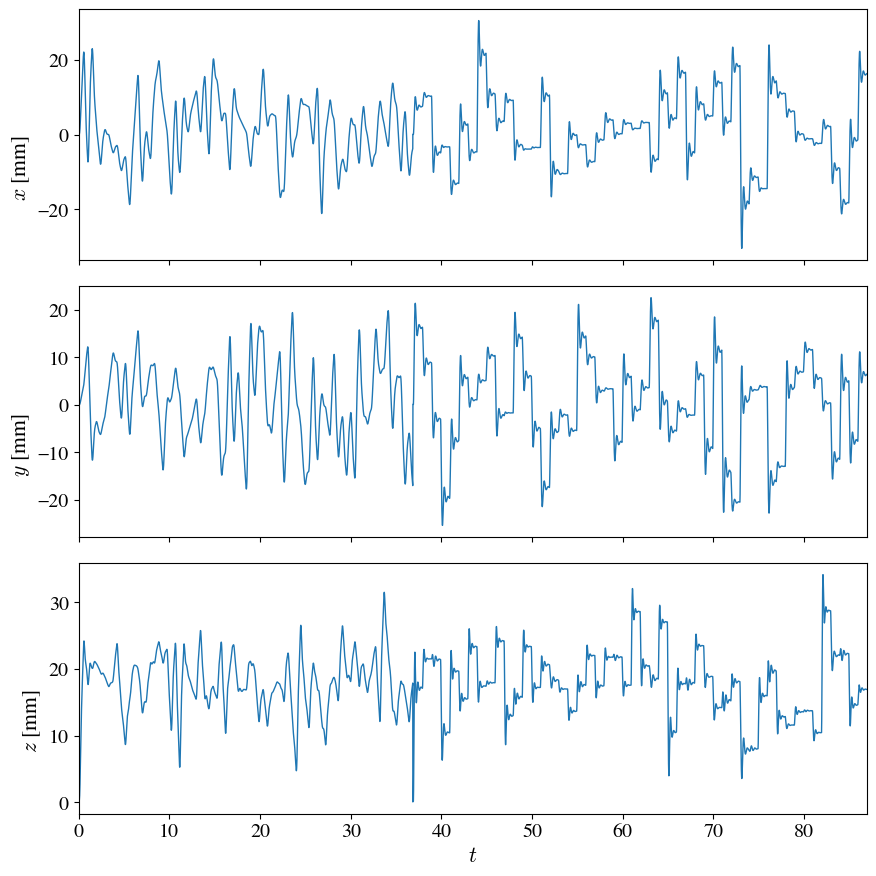

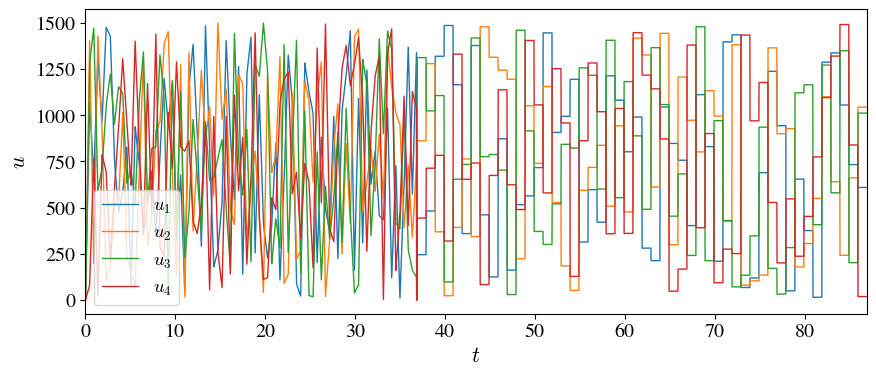

In [73]:
plt.close('all')
plot.traj_xyz_txyz(t=t_train,
                   x=z_shift_train[0, :], y=z_shift_train[1, :], z=z_shift_train[2, :])
plot.inputs(t_train, u_train)

Do delay embedding on the tip position (and optionally, on the inputs). Then, compute reduced coordinates and gradient as predicted by reduced dynamics, as well as the numerical (true) gradient

In [74]:
# delay-embed tip position (as well as inputs?). Single delay only
N_DELAY = 1
# DEBUG: Change to original
# N_DELAY = 4

y_train = utils.delayEmbedding(z_shift_train, embed_coords=[0, 1, 2], up_to_delay=N_DELAY)
print(f"y.shape: {y_train.shape}, u.shape: {u_train.shape}")
# reduced coordinates
print(t_train[:5])
x_train = Wauton(y_train)
print(x_train[0, :5])
dxDt = np.gradient(x_train, dt, axis=1)
dxDt_ROM = Rauton(x_train)

# optionally, throw away some of the training data
# keep_indices = np.s_[4000:-100]
keep_indices = np.s_[30:-20]
# DEBUG: Change keep_indices
# keep_indices = np.s_[10:-10]

t_train_trunc = t_train[keep_indices]
u_train_trunc = u_train[:, keep_indices]
x_train_trunc = x_train[:, keep_indices]
y_train_trunc = y_train[:, keep_indices]
dxDt = dxDt[:, keep_indices]
dxDt_ROM = dxDt_ROM[:, keep_indices]

print(t_train.shape)

y.shape: (6, 8692), u.shape: (4, 8692)
[0.   0.01 0.02 0.03 0.04]
[-0.01297724 -0.03796213 -0.06644354 -0.09720225 -0.12908112]
(8692,)


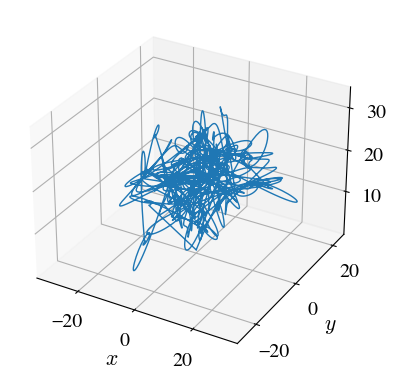

In [75]:
plt.close('all')
ax = plot.traj_3D_xyz(y_train_trunc[outdofs[0], :],
                      y_train_trunc[outdofs[1], :],
                      y_train_trunc[outdofs[2], :], show=True)

Plot gradients (numerical differentiation and reduced dynamics)

(6, 8642)


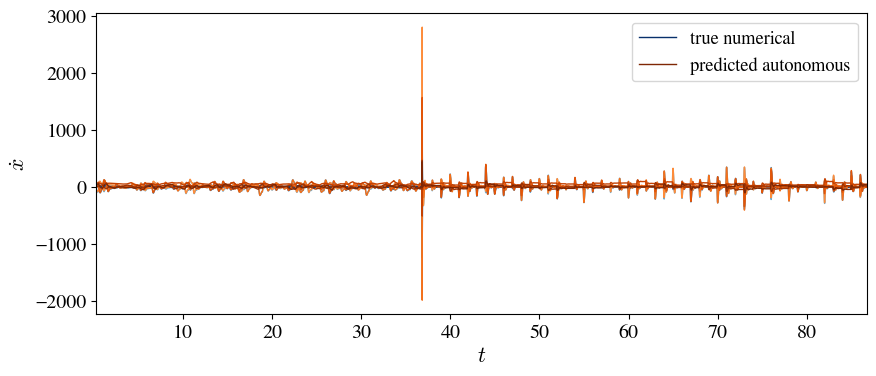

In [76]:
print(dxDt.shape)
plot.reduced_coordinates_gradient(t_train_trunc, [dxDt, dxDt_ROM], labels=["true numerical", "predicted autonomous"], how="all")

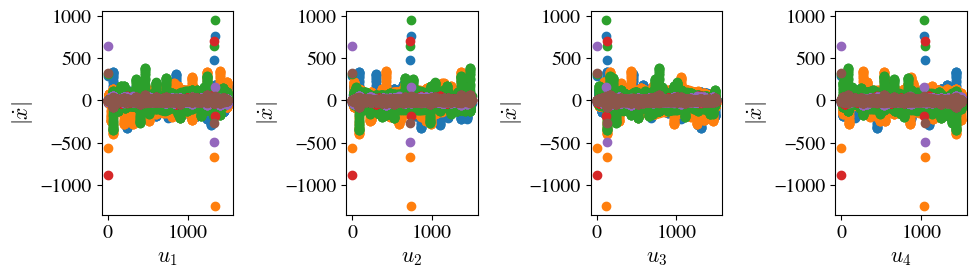

In [77]:
plt.close('all')
plot.dependence_of_xdot_on_inputs(dxDt, u_train_trunc)

Learn $B$ matrix

In [78]:
from sklearn.linear_model import Ridge

polyUorder = 1
# assemble_features = lambda u, x: utils.multivariate_polynomial(np.vstack([u, x]), order=polyUorder)
assemble_features = lambda u, x: utils.multivariate_polynomial(u, order=polyUorder)

X = assemble_features(u_train_trunc, x_train_trunc)
print(X.shape)

ridgeModel = Ridge(alpha=1000, fit_intercept=False)
ridgeModel.fit(X.T, (dxDt - dxDt_ROM).T)
B_learn = ridgeModel.coef_
print(B_learn.shape)

(4, 8642)
(6, 4)


Frobenius norm of $B_{learn}$ to estimate how much influence inputs have on dynamics

In [79]:
print(f"Frobenius norm of B_learn: {np.linalg.norm(B_learn, ord='fro'):.4f}")

Frobenius norm of B_learn: 0.0757


Plot gradients again, but this time, using the learned influence of inputs for the prediction

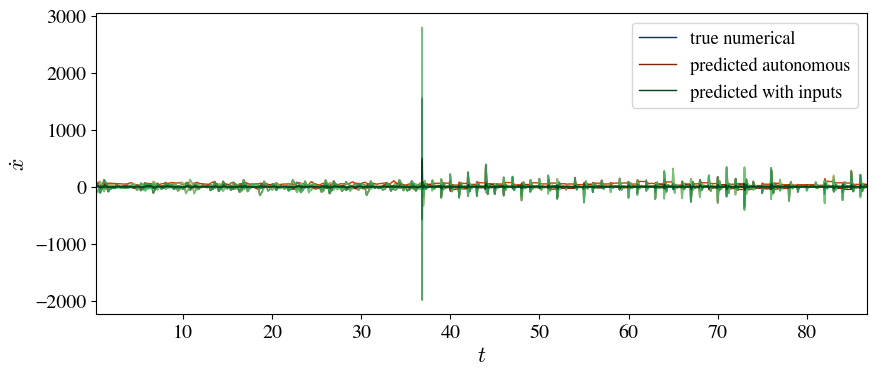

In [80]:
plt.close('all')
plot_reduced_coords = np.s_[:] # [3, 4, 5]
dxDt_ROM_with_B = Rauton(x_train_trunc) + B_learn @ assemble_features(u_train_trunc, x_train_trunc) # utils.multivariate_polynomial(u_train_trunc, order=polyUorder)
plot.reduced_coordinates_gradient(t_train_trunc, [dxDt[plot_reduced_coords, :], dxDt_ROM[plot_reduced_coords, :], dxDt_ROM_with_B[plot_reduced_coords, :]], labels=["true numerical", "predicted autonomous", "predicted with inputs"], how="all")

In [81]:
# # home-brewed ridge regression
# alpha = 0
# X, y = U.T, (dXbarDt - dXbarDt_ROM).T
# B_learn = np.linalg.solve(X.T @ X + alpha * np.eye(X.shape[0]), X.T @ y)

### Integrate model with inputs (big amplitude) -- and using learned influence of control

Try to predict the training trajectory using reduced dynamics

In [82]:
# Load the controls and actual trajectories for figure8
u_test = np.loadtxt("../../system_data/u_big.csv", delimiter=',').T
z_test = np.loadtxt("../../system_data/z_big.csv", delimiter=',').T
z_eq_test = np.loadtxt("../../system_data/z_equilibrium.csv", delimiter=',')
print(z_test.shape)
# tip position, normalized using resting position
z_shift_test = (z_test[-3:, :].T - z_eq_test).T
# delay-embed tip position (as well as inputs?)
y_test = utils.delayEmbedding(z_shift_test, embed_coords=[0, 1, 2], up_to_delay=N_DELAY)
# reduced coordinates
x_test = Wauton(y_test)

# original spacing of inputs
T = 10.01
dt = 0.01
N = int(T / dt)
t_test = np.linspace(0, T, N+1)

slice_traj = np.s_[30:-20]
t_test = t_test[slice_traj]
u_test = u_test[:, slice_traj]
x_test = x_test[:, slice_traj]
z_test = z_test[:, slice_traj]

(6, 1002)


(3, 952)


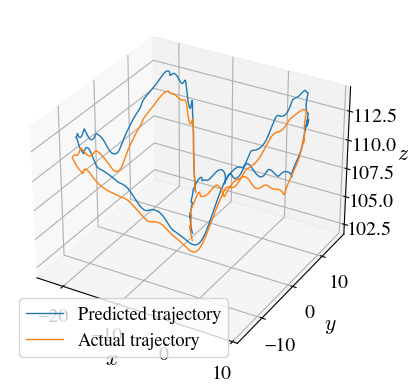

In [83]:
uInterpFun = interp1d(t_test, u_test, axis=1, fill_value="extrapolate")
uFun = lambda t: uInterpFun(t).reshape(-1, 1)
# print(t_test.shape, dxDt.shape)
# dxDtInterpFun = interp1d(t_test, dxDt_ROM, axis=1, fill_value="extrapolate")
def R(t, y):
    return Rauton(np.atleast_2d(y)) + B_learn @ assemble_features(uFun(t), y) # utils.multivariate_polynomial(uFun(t), order=polyUorder)
    # return dxDtInterpFun(t)

# solve IVP of reduced dynamics using open-loop figure8 inputs
sol = solve_ivp(R,
                t_span=[t_test[0], t_test[-1]],
                t_eval=t_test,
                y0=x_test[:, 0], # np.zeros(2*rDOF),
                method='RK45',
                vectorized=True,
                rtol=1e-3,
                atol=1e-3)
# resulting (predicted) open-loop trajectory in reduced coordinates
xTraj = sol.y
yTraj = Vauton(xTraj)[:-3, :]
zTraj = (yTraj.T + z_eq_test).T
print(zTraj.shape)

plt.close('all')
ax = plot.traj_3D_xyz(zTraj[0, :],
                      zTraj[1, :],
                      zTraj[2, :], show=False)
ax = plot.traj_3D_xyz(z_test[3, :],
                      z_test[4, :],
                      z_test[5, :], color="tab:orange", ax=ax, show=False)
ax.legend(["Predicted trajectory", "Actual trajectory"])
plt.show()

In [87]:
RMSE = np.sum(np.sqrt(np.mean((zTraj[0:3, :] - z_test[-3:])**2, axis=0))) / zTraj.shape[1]
print(f"RMSE = {RMSE:.4f}")
oDOF

RMSE = 0.8500


3

In [1]:
B_learn

NameError: name 'tanspace0_not_orth' is not defined

## Save SSM model

Continuous model

In [88]:
SSM_model = {'model': {}, 'params': {}}
print(N_DELAY)

SSM_model['model']['w_coeff'] = IMInfo['parametrization']['H']
SSM_model['model']['v_coeff'] = IMInfo['chart']['H']

SSM_model['model']['r_coeff'] = RDInfo['reducedDynamics']['coefficients']
SSM_model['model']['B'] = B_learn
SSM_model['model']['V'] = None

SSM_model['params']['SSM_order'] = SSMOrder
SSM_model['params']['ROM_order'] = ROMOrder
SSM_model['params']['state_dim'] = SSMDim # 2 * rDOF
print(SSMDim)
# print(2*rDOF)
SSM_model['params']['input_dim'] = B_learn.shape[1]

SSM_model['params']['delays'] = N_DELAY
SSM_model['params']['obs_dim'] = 3 * (1 + N_DELAY)
SSM_model['params']['delay_embedding'] = True
SSM_model['params']['output_dim'] = oDOF # Care only about position

# print(Data['yData'][0][1].shape[0])

1
6


In [89]:
import pickle
# save dictionary to person_data.pkl file
with open('../../../soft-robot-control/examples/hardware/SSMmodels/SSM_model_delayEmbeddingSingle.pkl', 'wb') as f:
    pickle.dump(SSM_model, f)